<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_VonMisesFisher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE with Von Mises-Fisher distribution

Variational Autoencoder Model (VAE) (https://arxiv.org/pdf/1312.6114.pdf) with the Von Mises–Fisher distribution (https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution) in the latent space. 

https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/VonMisesFisher

In [0]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('ggplot')

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=5000, centers=5, n_features=32,random_state=1)

In [0]:
def normalize_data(X):
  return (X-np.mean(X,axis=0)/np.std(X,axis=0))

In [0]:
X = normalize_data(X)

In [0]:
#Multivariate diagional
def create_encoder(inpt, latent_size, activation):
  x = inpt
  x = tf.layers.dense(x, 16, activation)
  x = tf.layers.dense(x, 8, activation)
  x = tf.layers.dense(x, 4, activation)
  direction = tf.layers.dense(x,latent_size)
  direction = direction/tf.norm(direction, axis=-1, keepdims=True)
  return tfd.VonMisesFisher(mean_direction=direction, concentration=25.0)

def create_prior(latent_size):
  return tfd.VonMisesFisher(mean_direction=[0., 0., 1.], concentration=0.)

def create_decoder(inpt, output_size, activation):
  x = inpt
  x = tf.layers.dense(x, 4, activation)
  x = tf.layers.dense(x, 8, activation)
  x = tf.layers.dense(x, 16, activation)
  loc = tf.layers.dense(x, output_size)
  scale = tf.ones(output_size)
  return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x')
latent_size = 3

latent_prior = create_prior(latent_size=latent_size)
latent_posterior = create_encoder(x, latent_size, tf.nn.elu)

latent_sampled = latent_posterior.sample()
latent_mean = latent_posterior.mean()

posterior = create_decoder(latent_sampled, X.shape[1], tf.nn.elu)

posterior_sampled = posterior.sample()
posterior_mean = posterior.mean()

rec_loss = -tf.reduce_mean(posterior.log_prob(x))
#kl = tf.reduce_mean(tfd.kl_divergence(latent_posterior, latent_prior)) #analytical
kl = tf.reduce_mean(latent_posterior.log_prob(latent_sampled)- latent_prior.log_prob(latent_sampled)) #approximate KL
beta=1.0
kl_loss = beta*kl
loss = rec_loss + kl_loss
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [0]:
#Helper function
def batch_generator(features, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:]

In [12]:
n_epochs = 30
batch_size = 25
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    gen = batch_generator(X, batch_size) #create batch generator
    total_loss = 0
    total_rec_loss = 0
    for j in range(np.int(X.shape[0]/batch_size)):
      x_batch = gen.__next__()
      _, total_loss_, total_rec_loss_ = sess.run([optimizer, loss, rec_loss], feed_dict={x: x_batch})
      total_loss += total_loss_
      total_rec_loss += total_rec_loss_
    if (i+1)% 10 == 0 or i == 0:
      #latent_mean_, latent_sampled_, posterior_mean_, posterior_sampled_= sess.run([latent_mean, latent_sampled, posterior_mean, posterior_sampled], feed_dict ={x:X})
      end = time.time()
      print('epoch: {0}, total_loss: {1:.2f}, rec_loss: {2:.2f}, time: {3:.2f}'.format((i+1), 
                                       total_loss/(1+np.int(X.shape[0]/batch_size)), total_rec_loss/(1+np.int(X.shape[0]/batch_size)), end-start))
      start = time.time()
  latent_mean_, latent_sampled_, posterior_mean_, posterior_sampled_= sess.run([latent_mean, latent_sampled, posterior_mean, posterior_sampled], feed_dict ={x:X})

epoch: 1, total_loss: 541.78, rec_loss: 538.87, time: 1.04
epoch: 10, total_loss: 61.88, rec_loss: 58.99, time: 6.48
epoch: 20, total_loss: 53.92, rec_loss: 51.03, time: 7.17
epoch: 30, total_loss: 52.28, rec_loss: 49.40, time: 7.08


In [13]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

configure_plotly_browser_state()

init_notebook_mode(connected=False)


import plotly.graph_objs as go


trace1 = go.Scatter3d(
    x=latent_sampled_[:,0],
    y=latent_sampled_[:,1],
    z=latent_sampled_[:,2],
    name = 'train data: line',
    mode='markers',
    marker=dict(
        size=2,
        color=y,                # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.8
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)



fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

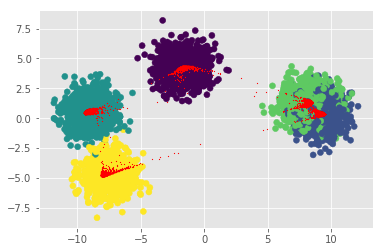

In [14]:
plt.scatter(X[:,0], X[:,1], c=y);
plt.scatter(posterior_mean_[:,0],posterior_mean_[:,1], c='red', s=0.5);

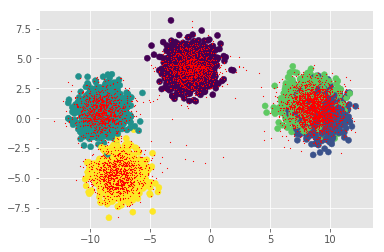

In [15]:
plt.scatter(X[:,0], X[:,1], c=y);
plt.scatter(posterior_sampled_[:,0],posterior_sampled_[:,1], c='red', s=0.5);